In [10]:
import numpy as np
import pandas as pd
import itertools
import gc
import psycopg2
import getpass
# for configuring connection 
from configobj import ConfigObj
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = '192.168.60.144'
    conn_info["sqlport"] = 6432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == '192.168.60.144') & (conn_info["sqlport"]=='6432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


In [3]:
from sqlalchemy import create_engine,text

con = create_engine(
    f'postgresql://{conn_info["sqluser"]}:{conn_info["sqlpass"]}@{conn_info["sqlhost"]}:{conn_info["sqlport"]}/{conn_info["dbname"]}',
    connect_args={'options': '-c search_path=eicu_crd'}
)

In [9]:
create_table_query =  query_schema +"""
drop materialized view if exists timeserieslab cascade;
create materialized view timeserieslab as
  select l.patientunitstayid as patient, l.labresultoffset, l.labname,l.labresult
    from lab as l
    inner join (
    select distinct patient from id
  ) id_unique 
      on id_unique.patient = l.patientunitstayid -- only extract data for the cohort
    where l.labresultoffset > 0;

"""

with con.begin() as connection:
    connection.execute(text(create_table_query)) 

select_query = "SELECT * FROM timeserieslab;"
df_lab = pd.read_sql_query(select_query, con)

print("there are {} patiets and {} records in lab test table".format(df_lab["patient"].nunique(),df_lab["patient"].count()))

there are 3072 patiets and 702430 records in lab test table


In [10]:
timeseries_lab = df_lab.copy()
timeseries_lab = timeseries_lab[timeseries_lab['labresultoffset'] <= 11*24*60]
timeseries_lab.set_index(['patient','labresultoffset'], inplace=True)
timeseries_lab.rename(round_up, level = 'labresultoffset', inplace = True)
timeseries_lab.sort_index(inplace=True)

In [11]:
lab = process_vital_signs(timeseries_lab,'labresultoffset',lab=True)

==> Reconfiguring lab test timeseries...
==> Filtering out invalid values with the possible value ranges...
There are 3072 patients and 112493 records in the vital periodic table.
==> Filtering out outliers...
select valid vlaue of vital signs
There are 3072 patients and 112493 records in the vital periodic table.
==> Normalizing data...


In [12]:
hdf= '/home/mei/nas/docker/thesis/data/hdf/'
vital = pd.read_hdf(hdf + 'vital_6_8.h5', key='vital_6_8')
l = lab.copy()
l.columns = l.columns.droplevel(0)
## get common patients
common_patients = list(set(l.index.get_level_values(0)) & set(vital.index.get_level_values(0)))
print("there are {} common patients".format(len(common_patients)))

l = l.loc[l.index.get_level_values(0).isin(common_patients)]
vital = vital.loc[vital.index.get_level_values(0).isin(common_patients)]
print("there are {} patients in vital and {} patients in lab".format(vital.index.get_level_values(0).nunique(),l.index.get_level_values(0).nunique()))
print("there are {} records in vital and {} records in lab".format(vital.shape[0],l.shape[0]))
print('==> Combining data together...')
merged =  pd.concat([l, vital], axis=0, sort=False)
print("there are {} patients in the merged table and {} records.".format(len(list(merged.index.get_level_values(0).unique())),len(merged)))

there are 3072 common patients
there are 3072 patients in vital and 3072 patients in lab
there are 2101463 records in vital and 112493 records in lab
==> Combining data together...
there are 3072 patients in the merged table and 2213956 records.


In [13]:
merged.to_hdf(hdf+'merged_ts.h5', key='df', mode='w', format='table')

In [22]:
def count_time_steps(final):
    
    # 1. 每个病人的最大时间长度
    patient_max_time = final.reset_index().groupby('patient')['time'].max()

    # 2. 按500分组统计
    step = 500
    max_time = patient_max_time.max()
    bins = np.arange(0, max_time + step, step)

    # 3. 用pd.cut分箱
    bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
    patient_bins = pd.cut(patient_max_time, bins=bins, labels=bin_labels, right=False)

    # 4. 每个区间的病人数
    counts = patient_bins.value_counts().sort_index()

    for label, num in counts.items():
        print(f"Max time {label}: {num} patients")
        
    ##  the max time step
    print("the  total max time step is {}".format(final.index.get_level_values(1).max()))

In [ ]:
def resample(timeseries, freq='5min'):
    resampled_data = []
    for patient, group in timeseries.groupby(level=0):
        group = group.droplevel(0)
        group.index = group.index.ceil(freq=freq)
        resampled = group.resample(freq, closed='right', label='right').mean() # 均值
        
        # markers = resampled.notna().astype(int)

        # 1. linear interpolation for missing values
        resampled.interpolate(method='linear', limit_area='inside', inplace=True)
        # 2. forward fill for the rest
        resampled.ffill(inplace=True)
        # 3. backfill for the rest
        resampled.bfill(inplace=True)
        # 4. fill the rest with 0.5
        resampled.fillna(0.5, inplace=True)  
        # 5. smooth the data (lowess)
        resampled = moving_average_smoothing(resampled, window=40)
        
        n = len(resampled)
        resampled.reset_index(drop=True, inplace=True)
        # markers.reset_index(drop=True, inplace=True)
        
        new_cols = pd.DataFrame({
            'patient': [patient] * n,
            'time': np.arange(1, n + 1)
        })
        resampled = pd.concat([new_cols, resampled], axis=1)
        # markers = pd.concat([new_cols, markers], axis=1)
        
        resampled.set_index(['patient', 'time'], inplace=True)
        # markers.set_index(['patient', 'time'], inplace=True)
        
        # resampled = pd.concat([resampled, markers.add_suffix('_marker')], axis=1)
        resampled = resampled.copy() 
        resampled_data.append(resampled)
    final = pd.concat(resampled_data)
    
    
    return final

# resample 5 min #

In [ ]:
patients = merged.index.unique(level=0)
gen_chunks = gen_patient_chunk(patients, merged)
header = True
print('==> Initiating main processing loop...')

for i, patient_chunk in enumerate(gen_chunks, start=1):
    final = resample(patient_chunk, freq='5min')
    final.to_hdf(hdf + "final_timeseries.h5", key="df", mode="a", complevel=5, complib="zlib", format="table", append=True)

    print(f'==> Processed {i * 500} patients...')
    
    del patient_chunk # free up memory
    gc.collect()

==> Initiating main processing loop...
==> Processed 500 patients...
==> Processed 1000 patients...
==> Processed 1500 patients...
==> Processed 2000 patients...
==> Processed 2500 patients...
==> Processed 3000 patients...
==> Processed 3500 patients...


In [23]:
hdf= '/home/mei/nas/docker/thesis/data/hdf/'
final_ts= pd.read_hdf(hdf+ "final_timeseries.h5", key="df") # key is the name of the key in the hdf file
final_ts

-bands  -basos      -eos   -lymphs    -monos    -polys  \
patient time                                                           
260132  1        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        2        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        3        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        4        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        5        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
...              ...     ...       ...       ...       ...       ...   
3247116 2328     0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        2329     0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        2330     0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        2331     0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        2332     0.5     0.0  0.000000  0.023529  0.142857  0.500000   

              24 h urine protein  24 h urine urea nitrogen  ALT (SGPT)  \
patient time                                                             
260132  1                    0.5                       0.5     0.50000   
        2                    0.5                       0.5     0.50000   
        3                    0.5                       0.5     0.50000   
        4                    0.5                       0.5     0.50000   
        5                    0.5                       0.5     0.50000   
...                          ...                       ...         ...   
3247116 2328                 0.5                       0.5     0.01897   
        2329                 0.5                       0.5     0.01897   
        2330                 0.5                       0.5     0.01897   
        2331                 0.5                       0.5     0.01897   
        2332                 0.5                       0.5     0.01897   

              ANF/ANA  ...      sao2  heartrate  respiration       cvp  \
patient time           ...                                               
260132  1         0.5  ...  0.914286   0.289474     0.509434  0.600000   
        2         0.5  ...  0.914286   0.289474     0.509434  0.600000   
        3         0.5  ...  0.914286   0.289474     0.509434  0.600000   
        4         0.5  ...  0.914286   0.289474     0.509434  0.600000   
        5         0.5  ...  0.914286   0.289474     0.509434  0.600000   
...               ...  ...       ...        ...          ...       ...   
3247116 2328      0.5  ...  0.890286   0.602807     0.443774  0.854000   
        2329      0.5  ...  0.890476   0.601974     0.444182  0.854167   
        2330      0.5  ...  0.889441   0.601449     0.432322  0.854348   
        2331      0.5  ...  0.888312   0.600080     0.433962  0.852273   
        2332      0.5  ...  0.887075   0.598580     0.434861  0.847619   

              systemicsystolic  systemicdiastolic  systemicmean  st1  \
patient time                                                           
260132  1             0.095808           0.063636      0.058394  0.5   
        2             0.095808           0.063636      0.058394  0.5   
        3             0.095808           0.063636      0.058394  0.5   
        4             0.095808           0.063636      0.058394  0.5   
        5             0.095808           0.063636      0.058394  0.5   
...                        ...                ...           ...  ...   
3247116 2328          0.581317           0.396000      0.463358  0.5   
        2329          0.581587           0.397348      0.464416  0.5   
        2330          0.576412           0.394466      0.459854  0.5   
        2331          0.570495           0.391322      0.455209  0.5   
        2332          0.565726           0.389177      0.451860  0.5   

                   st2  st3  
patient time                 
260132  1     0.015778  0.5  
        2     0.015778  0.5  
        3     0.015778  0.5  
        4     0.015778  0.5  
        5     0.015778  0.5  
... 

In [24]:
count_time_steps(final_ts)


Max time 0-500: 632 patients
Max time 500-1000: 504 patients
Max time 1000-1500: 597 patients
Max time 1500-2000: 469 patients
Max time 2000-2500: 305 patients
Max time 2500-3000: 233 patients
Max time 3000-3500: 332 patients
the  total max time step is 3169


# resample 15 min ##

In [ ]:
patients = merged.index.unique(level=0)
gen_chunks = gen_patient_chunk(patients, merged)
header = True
print('==> Initiating main processing loop...')

for i, patient_chunk in enumerate(gen_chunks, start=1):
    final = resample(patient_chunk, freq='15min')
    final.to_hdf(hdf + "final_timeseries_15min.h5", key="df", mode="a", complevel=5, complib="zlib", format="table", append=True)

    print(f'==> Processed {i * 500} patients...')
    
    del patient_chunk # free up memory
    gc.collect()

In [16]:
hdf= '/home/mei/nas/docker/thesis/data/hdf/'
final_ts_15= pd.read_hdf(hdf+ "final_timeseries_15min.h5", key="df") # key is the name of the key in the hdf file
final_ts_15

-bands  -basos      -eos   -lymphs    -monos    -polys  \
patient time                                                           
260132  1        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        2        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        3        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        4        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        5        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
...              ...     ...       ...       ...       ...       ...   
3247116 774      0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        775      0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        776      0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        777      0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        778      0.5     0.0  0.000000  0.023529  0.142857  0.500000   

              24 h urine protein  24 h urine urea nitrogen  ALT (SGPT)  \
patient time                                                             
260132  1                    0.5                       0.5     0.50000   
        2                    0.5                       0.5     0.50000   
        3                    0.5                       0.5     0.50000   
        4                    0.5                       0.5     0.50000   
        5                    0.5                       0.5     0.50000   
...                          ...                       ...         ...   
3247116 774                  0.5                       0.5     0.01897   
        775                  0.5                       0.5     0.01897   
        776                  0.5                       0.5     0.01897   
        777                  0.5                       0.5     0.01897   
        778                  0.5                       0.5     0.01897   

              ANF/ANA  ...      sao2  heartrate  respiration       cvp  \
patient time           ...                                               
260132  1         0.5  ...  0.921726   0.277686     0.502358  0.531771   
        2         0.5  ...  0.921726   0.277686     0.502358  0.531771   
        3         0.5  ...  0.921726   0.277686     0.502358  0.531771   
        4         0.5  ...  0.921726   0.277686     0.502358  0.531771   
        5         0.5  ...  0.921726   0.277686     0.502358  0.531771   
...               ...  ...       ...        ...          ...       ...   
3247116 774       0.5  ...  0.853206   0.610760     0.434969  0.750667   
        775       0.5  ...  0.852381   0.610136     0.437369  0.740278   
        776       0.5  ...  0.851346   0.609586     0.439978  0.728986   
        777       0.5  ...  0.850072   0.609117     0.442824  0.716667   
        778       0.5  ...  0.848526   0.608744     0.445942  0.703175   

              systemicsystolic  systemicdiastolic  systemicmean  st1  \
patient time                                                           
260132  1             0.062250           0.041667      0.031402  0.5   
        2             0.062250           0.041667      0.031402  0.5   
        3             0.062250           0.041667      0.031402  0.5   
        4             0.062250           0.041667      0.031402  0.5   
        5             0.062250           0.041667      0.031402  0.5   
...                        ...                ...           ...  ...   
3247116 774           0.549381           0.432040      0.461736  0.5   
        775           0.552312           0.428030      0.461172  0.5   
        776           0.556799           0.422398      0.460489  0.5   
        777           0.563056           0.414922      0.459670  0.5   
        778           0.571334           0.405339      0.458695  0.5   

                   st2  st3  
patient time                 
260132  1     0.016023  0.5  
        2     0.016023  0.5  
        3     0.016023  0.5  
        4     0.016023  0.5  
        5     0.016023  0.5  
... 

In [ ]:
count_time_steps(final_ts_15)

Max time 0-500: 1732 patients
Max time 500-1000: 1003 patients
Max time 1000-1500: 337 patients
the  total max time step is 1058


# resample 30 min #

In [20]:
gen_chunks = gen_patient_chunk(patients, merged)
header = True
print('==> Initiating main processing loop for resampling 30 min...')

for i, patient_chunk in enumerate(gen_chunks, start=1):
    final = resample(patient_chunk, freq='30min')
    final.to_hdf(hdf + "final_timeseries_30min.h5", key="df", mode="a", complevel=5, complib="zlib", format="table", append=True)

    print(f'==> Processed {i * 500} patients...')
    
    del patient_chunk # free up memory
    gc.collect()

==> Initiating main processing loop for resampling 30 min...
==> Processed 500 patients...
==> Processed 1000 patients...
==> Processed 1500 patients...
==> Processed 2000 patients...
==> Processed 2500 patients...
==> Processed 3000 patients...
==> Processed 3500 patients...


In [21]:
hdf= '/home/mei/nas/docker/thesis/data/hdf/'
final_ts_30= pd.read_hdf(hdf+ "final_timeseries_30min.h5", key="df") # key is the name of the key in the hdf file
final_ts_30

-bands  -basos      -eos   -lymphs    -monos    -polys  \
patient time                                                           
260132  1        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        2        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        3        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        4        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        5        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
...              ...     ...       ...       ...       ...       ...   
3247116 386      0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        387      0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        388      0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        389      0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        390      0.5     0.0  0.000000  0.023529  0.142857  0.500000   

              24 h urine protein  24 h urine urea nitrogen  ALT (SGPT)  \
patient time                                                             
260132  1                    0.5                       0.5     0.50000   
        2                    0.5                       0.5     0.50000   
        3                    0.5                       0.5     0.50000   
        4                    0.5                       0.5     0.50000   
        5                    0.5                       0.5     0.50000   
...                          ...                       ...         ...   
3247116 386                  0.5                       0.5     0.01897   
        387                  0.5                       0.5     0.01897   
        388                  0.5                       0.5     0.01897   
        389                  0.5                       0.5     0.01897   
        390                  0.5                       0.5     0.01897   

              ANF/ANA  ...      sao2  heartrate  respiration       cvp  \
patient time           ...                                               
260132  1         0.5  ...  0.919894   0.278200     0.503005  0.532407   
        2         0.5  ...  0.919894   0.278200     0.503005  0.532407   
        3         0.5  ...  0.919894   0.278200     0.503005  0.532407   
        4         0.5  ...  0.919894   0.278200     0.503005  0.532407   
        5         0.5  ...  0.919894   0.278200     0.503005  0.532407   
...               ...  ...       ...        ...          ...       ...   
3247116 386       0.5  ...  0.848762   0.605673     0.420881  0.684667   
        387       0.5  ...  0.845040   0.607273     0.422432  0.694444   
        388       0.5  ...  0.841615   0.608441     0.423024  0.705435   
        389       0.5  ...  0.841342   0.609051     0.425958  0.720076   
        390       0.5  ...  0.841950   0.610693     0.427673  0.735317   

              systemicsystolic  systemicdiastolic  systemicmean  st1  \
patient time                                                           
260132  1             0.062342           0.041582      0.031711  0.5   
        2             0.062342           0.041582      0.031711  0.5   
        3             0.062342           0.041582      0.031711  0.5   
        4             0.062342           0.041582      0.031711  0.5   
        5             0.062342           0.041582      0.031711  0.5   
...                        ...                ...           ...  ...   
3247116 386           0.544830           0.400242      0.439903  0.5   
        387           0.543413           0.401957      0.439984  0.5   
        388           0.542480           0.404084      0.440601  0.5   
        389           0.545318           0.407989      0.444371  0.5   
        390           0.548665           0.411616      0.448326  0.5   

                   st2  st3  
patient time                 
260132  1     0.016026  0.5  
        2     0.016026  0.5  
        3     0.016026  0.5  
        4     0.016026  0.5  
        5     0.016026  0.5  
... 

In [26]:
count_time_steps(final_ts_30)

Max time 0-500: 2728 patients
Max time 500-1000: 344 patients
the  total max time step is 530


# resample 1h #

In [27]:
gen_chunks = gen_patient_chunk(patients, merged)
header = True
print('==> Initiating main processing loop for resampling 1h...')

for i, patient_chunk in enumerate(gen_chunks, start=1):
    final = resample(patient_chunk, freq='60min')
    final.to_hdf(hdf + "final_timeseries_60min.h5", key="df", mode="a", complevel=5, complib="zlib", format="table", append=True)

    print(f'==> Processed {i * 500} patients...')
    
    del patient_chunk # free up memory
    gc.collect()

==> Initiating main processing loop for resampling 1h...
==> Processed 500 patients...
==> Processed 1000 patients...
==> Processed 1500 patients...
==> Processed 2000 patients...
==> Processed 2500 patients...
==> Processed 3000 patients...
==> Processed 3500 patients...


In [28]:
hdf= '/home/mei/nas/docker/thesis/data/hdf/'
final_ts_60= pd.read_hdf(hdf+ "final_timeseries_60min.h5", key="df") # key is the name of the key in the hdf file
final_ts_60

-bands  -basos      -eos   -lymphs    -monos    -polys  \
patient time                                                           
260132  1        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        2        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        3        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        4        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
        5        0.5     0.1  0.027778  0.167059  0.121429  0.828358   
...              ...     ...       ...       ...       ...       ...   
3247116 192      0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        193      0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        194      0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        195      0.5     0.0  0.000000  0.023529  0.142857  0.500000   
        196      0.5     0.0  0.000000  0.023529  0.142857  0.500000   

              24 h urine protein  24 h urine urea nitrogen  ALT (SGPT)  \
patient time                                                             
260132  1                    0.5                       0.5    0.500000   
        2                    0.5                       0.5    0.500000   
        3                    0.5                       0.5    0.500000   
        4                    0.5                       0.5    0.500000   
        5                    0.5                       0.5    0.500000   
...                          ...                       ...         ...   
3247116 192                  0.5                       0.5    0.018679   
        193                  0.5                       0.5    0.018743   
        194                  0.5                       0.5    0.018801   
        195                  0.5                       0.5    0.018852   
        196                  0.5                       0.5    0.018896   

              ANF/ANA  ...      sao2  heartrate  respiration       cvp  \
patient time           ...                                               
260132  1         0.5  ...  0.928831   0.269258     0.498928  0.485341   
        2         0.5  ...  0.928831   0.269258     0.498928  0.485341   
        3         0.5  ...  0.928831   0.269258     0.498928  0.485341   
        4         0.5  ...  0.928831   0.269258     0.498928  0.485341   
        5         0.5  ...  0.928831   0.269258     0.498928  0.485341   
...               ...  ...       ...        ...          ...       ...   
3247116 192       0.5  ...  0.897388   0.553562     0.375157  0.599246   
        193       0.5  ...  0.895493   0.552910     0.375066  0.584400   
        194       0.5  ...  0.892192   0.554448     0.377427  0.568504   
        195       0.5  ...  0.888374   0.558285     0.379503  0.559118   
        196       0.5  ...  0.885439   0.561026     0.383947  0.551814   

              systemicsystolic  systemicdiastolic  systemicmean  st1      st2  \
patient time                                                                    
260132  1             0.043794           0.028306      0.016257  0.5  0.01613   
        2             0.043794           0.028306      0.016257  0.5  0.01613   
        3             0.043794           0.028306      0.016257  0.5  0.01613   
        4             0.043794           0.028306      0.016257  0.5  0.01613   
        5             0.043794           0.028306      0.016257  0.5  0.01613   
...                        ...                ...           ...  ...      ...   
3247116 192           0.507558           0.358939      0.402946  0.5  0.50000   
        193           0.511186           0.362910      0.406996  0.5  0.50000   
        194           0.515187           0.365250      0.410093  0.5  0.50000   
        195           0.519824           0.367218      0.413084  0.5  0.50000   
        196           0.516610           0.363781      0.409264  0.5  0.50000   

              st3  
patient time       
260132  1     0.5  
        2     0.5  
        3     0.5

In [29]:
count_time_steps(final_ts_60)

Max time 0-500: 3072 patients
the  total max time step is 266


# risk

In [37]:
create_table_query =  query_schema +"""
drop materialized view if exists risk_ts cascade;
create materialized view risk_ts as
  select id.patient, l.gender, l.age, l.dischargeweight,l.unitdischargestatus, l.discharge_risk_category, l.actualiculos 
    from labels as l
    inner join id  on id.patient = l.patient  
    order by id.patient

"""

with con.begin() as connection:
    connection.execute(text(create_table_query)) 

select_query = "SELECT * FROM risk_ts;"
df_risk = pd.read_sql_query(select_query, con)

print("there are {} patiets and {} records in lab test table".format(df_risk["patient"].nunique(),df_risk["patient"].count()))

there are 3072 patiets and 3072 records in lab test table


In [41]:
df_risk

,patient,gender,age,dischargeweight,unitdischargestatus,discharge_risk_category,actualiculos
0,260132,0,89.0,84.1,1,3,0.1819
1,261021,0,89.0,51.7,0,1,0.5291
2,270853,1,46.0,133.2,0,1,1.9437
3,282833,0,84.0,58.4,0,1,8.5041
4,306940,0,71.0,88.4,0,1,8.5798
...,...,...,...,...,...,...,...
3067,3246409,1,77.0,83.0,1,3,0.1923
3068,3246443,1,82.0,93.4,0,1,2.8791
3069,3246620,1,66.0,109.0,0,1,1.9180
3070,3246731,1,59.0,96.3,0,2,2.0854


In [42]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
df_risk[['age','dischargeweight']] = mm.fit_transform(df_risk[['age','dischargeweight']])

# resample 15 min #

In [43]:
ts = final_ts_15.reset_index()[['patient','time']]
df_risk_15 = df_risk.merge(ts, on='patient', how='left')
df_risk_15.insert(1, 'time', df_risk_15.pop('time'))
df_risk_15

,patient,time,gender,age,dischargeweight,unitdischargestatus,discharge_risk_category,actualiculos
0,260132,1,0,1.000000,0.363995,1,3,0.1819
1,260132,2,0,1.000000,0.363995,1,3,0.1819
2,260132,3,0,1.000000,0.363995,1,3,0.1819
3,260132,4,0,1.000000,0.363995,1,3,0.1819
4,260132,5,0,1.000000,0.363995,1,3,0.1819
...,...,...,...,...,...,...,...,...
1499036,3247116,774,0,0.471429,0.293473,1,3,8.1256
1499037,3247116,775,0,0.471429,0.293473,1,3,8.1256
1499038,3247116,776,0,0.471429,0.293473,1,3,8.1256
1499039,3247116,777,0,0.471429,0.293473,1,3,8.1256


# resample 30 min #

In [44]:
ts = final_ts_30.reset_index()[['patient','time']]
df_risk_30 = df_risk.merge(ts, on='patient', how='left')
df_risk_30.insert(1, 'time', df_risk_30.pop('time'))
df_risk_30

,patient,time,gender,age,dischargeweight,unitdischargestatus,discharge_risk_category,actualiculos
0,260132,1,0,1.000000,0.363995,1,3,0.1819
1,260132,2,0,1.000000,0.363995,1,3,0.1819
2,260132,3,0,1.000000,0.363995,1,3,0.1819
3,260132,4,0,1.000000,0.363995,1,3,0.1819
4,260132,5,0,1.000000,0.363995,1,3,0.1819
...,...,...,...,...,...,...,...,...
752075,3247116,386,0,0.471429,0.293473,1,3,8.1256
752076,3247116,387,0,0.471429,0.293473,1,3,8.1256
752077,3247116,388,0,0.471429,0.293473,1,3,8.1256
752078,3247116,389,0,0.471429,0.293473,1,3,8.1256


# resample 60 min #

In [45]:
ts = final_ts_60.reset_index()[['patient','time']]
df_risk_60 = df_risk.merge(ts, on='patient', how='left')
df_risk_60.insert(1, 'time', df_risk_60.pop('time'))
df_risk_60

,patient,time,gender,age,dischargeweight,unitdischargestatus,discharge_risk_category,actualiculos
0,260132,1,0,1.000000,0.363995,1,3,0.1819
1,260132,2,0,1.000000,0.363995,1,3,0.1819
2,260132,3,0,1.000000,0.363995,1,3,0.1819
3,260132,4,0,1.000000,0.363995,1,3,0.1819
4,260132,5,0,1.000000,0.363995,1,3,0.1819
...,...,...,...,...,...,...,...,...
378567,3247116,192,0,0.471429,0.293473,1,3,8.1256
378568,3247116,193,0,0.471429,0.293473,1,3,8.1256
378569,3247116,194,0,0.471429,0.293473,1,3,8.1256
378570,3247116,195,0,0.471429,0.293473,1,3,8.1256


In [26]:
hdf= '/home/mei/nas/docker/thesis/data/hdf/'

risks_15 = pd.read_hdf(os.path.join(hdf, 'final_risk_scores_15min.h5')).set_index('patient')
risks_30 = pd.read_hdf(os.path.join(hdf, 'final_risk_scores_30min.h5')).set_index('patient')
risks_60 = pd.read_hdf(os.path.join(hdf, 'final_risk_scores_60min.h5')).set_index('patient')


# risk score function ##

In [24]:
def risk_function_15(t, category):
    """
    Compute risk score given time t and discharge category.
    Categories:
    0 = Home (Risk decreasing to 0)
    1 = Rehab (Low risk, decreasing slowly)
    2 = Nursing (Moderate risk, slow decrease)
    3 = Dead (High risk, increasing)
    """
    if category == 0:
        return 0.5 * (1-np.exp(-0.005 * t) ) # Decreasing to 0
    elif category == 1:
        return 0.1 * (1-np.exp(-0.005 * t))+0.4  # Decreasing to 0.2
    elif category == 2:
        return 0.3 *  (np.exp(-0.005 * t)) + 0.5  # Decreasing to 0.8
    elif category == 3:
        return 0.5 * (np.exp(-0.005 * t)) + 0.5  # Increasing to 1
    else:
        raise ValueError("Invalid category. Should be in {0,1,2,3}.")

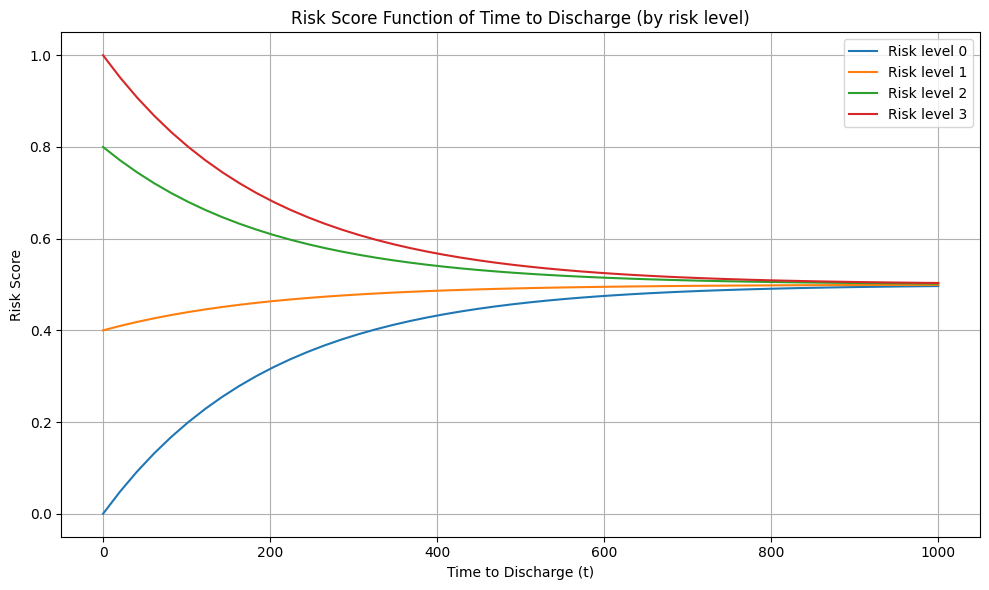

In [25]:
t_values = np.linspace(0, 1000, 50)

# Plot risk curves for each category
plt.figure(figsize=(10, 6))
for cat in range(4):
    risks = [risk_function_15(t, cat) for t in t_values]
    plt.plot(t_values, risks, label=f"Risk level {cat}")

plt.title("Risk Score Function of Time to Discharge (by risk level)")
plt.xlabel("Time to Discharge (t)")
plt.ylabel("Risk Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
def risk_function_30(t, category):
    """
    Compute risk score given time t and discharge category.
    Categories:
    0 = Home (Risk decreasing to 0)
    1 = Rehab (Low risk, decreasing slowly)
    2 = Nursing (Moderate risk, slow decrease)
    3 = Dead (High risk, increasing)
    """
    if category == 0:
        return 0.5 * (1-np.exp(-0.01 * t) ) # Decreasing to 0
    elif category == 1:
        return 0.1 * (1-np.exp(-0.01 * t))+0.4  # Decreasing to 0.2
    elif category == 2:
        return 0.3 *  (np.exp(-0.01 * t)) + 0.5  # Decreasing to 0.8
    elif category == 3:
        return 0.5 * (np.exp(-0.01 * t)) + 0.5  # Increasing to 1
    else:
        raise ValueError("Invalid category. Should be in {0,1,2,3}.")

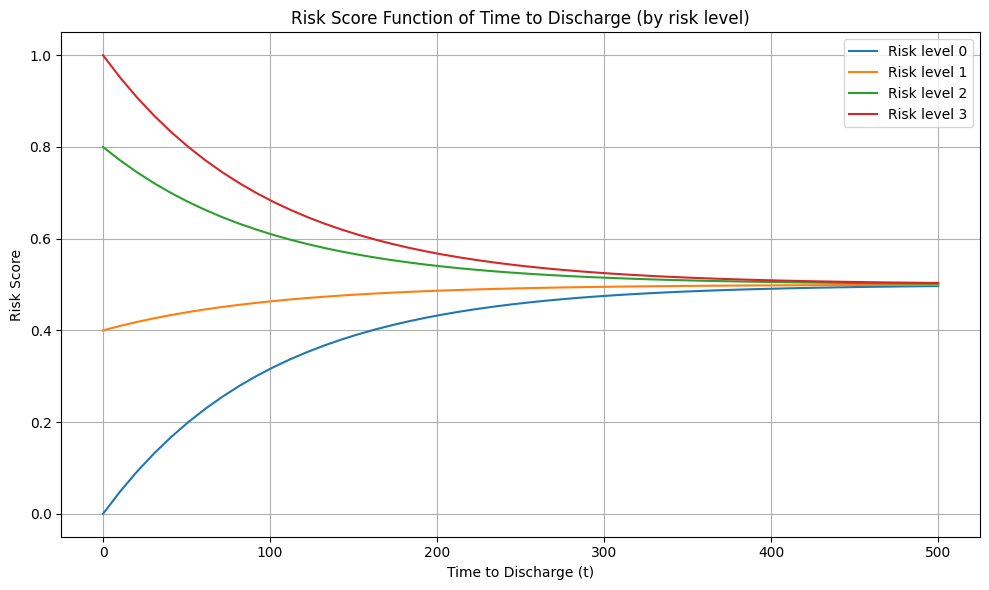

In [9]:
t_values = np.linspace(0, 500, 50)

# Plot risk curves for each category
plt.figure(figsize=(10, 6))
for cat in range(4):
    risks = [risk_function_30(t, cat) for t in t_values]
    plt.plot(t_values, risks, label=f"Risk level {cat}")

plt.title("Risk Score Function of Time to Discharge (by risk level)")
plt.xlabel("Time to Discharge (t)")
plt.ylabel("Risk Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
def risk_function_60(t, category):
    """
    Compute risk score given time t and discharge category.
    Categories:
    0 = Home (Risk decreasing to 0)
    1 = Rehab (Low risk, decreasing slowly)
    2 = Nursing (Moderate risk, slow decrease)
    3 = Dead (High risk, increasing)
    """
    if category == 0:
        return 0.5 * (1-np.exp(-0.02 * t) ) # Decreasing to 0
    elif category == 1:
        return 0.1 * (1-np.exp(-0.02 * t))+0.4  # Decreasing to 0.2
    elif category == 2:
        return 0.3 *  (np.exp(-0.02 * t)) + 0.5  # Decreasing to 0.8
    elif category == 3:
        return 0.5 * (np.exp(-0.02 * t)) + 0.5  # Increasing to 1
    else:
        raise ValueError("Invalid category. Should be in {0,1,2,3}.")

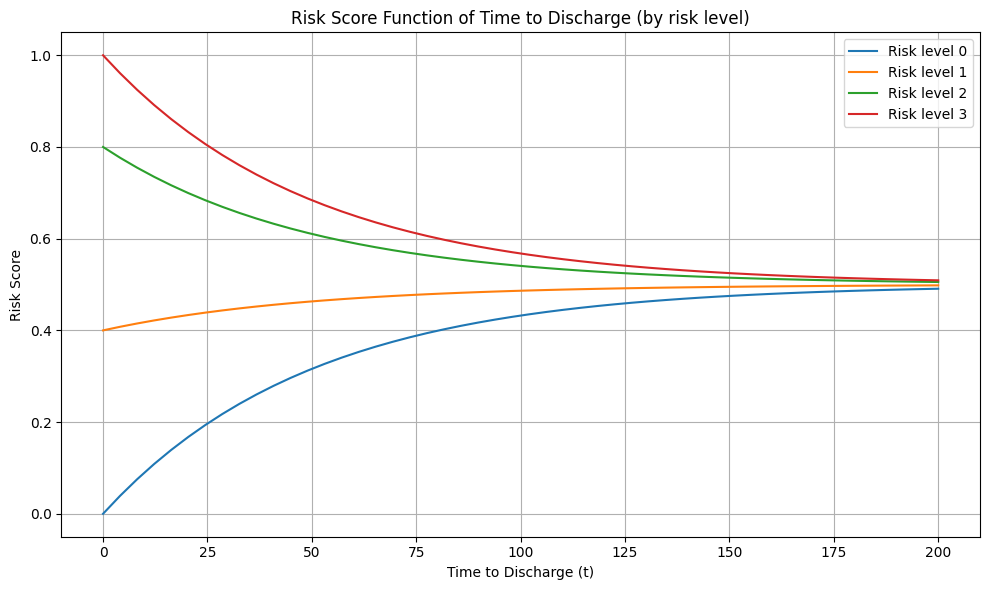

In [187]:
t_values = np.linspace(0, 200, 50)

# Plot risk curves for each category
plt.figure(figsize=(10, 6))
for cat in range(4):
    risks = [risk_function(t, cat) for t in t_values]
    plt.plot(t_values, risks, label=f"Risk level {cat}")

plt.title("Risk Score Function of Time to Discharge (by risk level)")
plt.xlabel("Time to Discharge (t)")
plt.ylabel("Risk Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## resampled 15 min

In [28]:
# max_times = risk_15.groupby('patient')['time'].max().reset_index()
# max_times.rename(columns={'time': 'max_time'}, inplace=True)

# # merge
# df_risk_15 = risk_15.merge(max_times, on='patient', how='left')
df_risk_15 = risks_15.copy()
df_risk_15 = df_risk_15.drop(columns=['risk_score'])

# 计算 risk_score
df_risk_15['risk_score'] = df_risk_15.apply(
    lambda row: risk_function_15(row['time_to_discharge'], row['discharge_risk_category']),
    axis=1
)

df_risk_15 

,time,gender,age,dischargeweight,unitdischargestatus,discharge_risk_category,actualiculos,time_to_discharge,risk_score
patient,,,,,,,,,
260132,1,0,1.000000,0.363995,1,3,0.1819,15,0.963872
260132,2,0,1.000000,0.363995,1,3,0.1819,14,0.966197
260132,3,0,1.000000,0.363995,1,3,0.1819,13,0.968534
260132,4,0,1.000000,0.363995,1,3,0.1819,12,0.970882
260132,5,0,1.000000,0.363995,1,3,0.1819,11,0.973243
...,...,...,...,...,...,...,...,...,...
3247116,774,0,0.471429,0.293473,1,3,8.1256,4,0.990099
3247116,775,0,0.471429,0.293473,1,3,8.1256,3,0.992556
3247116,776,0,0.471429,0.293473,1,3,8.1256,2,0.995025


## resampled 30 min

In [16]:
# max_times = risk_30.groupby('patient')['time'].max().reset_index()
# max_times.rename(columns={'time': 'max_time'}, inplace=True)

# # merge
# df_risk_30 = risk_30.merge(max_times, on='patient', how='left')

df_risk_30 = risks_30.copy()
# 计算距离出院时间
df_risk_30 = df_risk_30.drop(columns=['risk_score'])
# 计算 risk_score
df_risk_30['risk_score'] = df_risk_30.apply(
    lambda row: risk_function_30(row['time_to_discharge'], row['discharge_risk_category']),
    axis=1
)

df_risk_30 

,time,gender,age,dischargeweight,unitdischargestatus,discharge_risk_category,actualiculos,time_to_discharge,risk_score
patient,,,,,,,,,
260132,1,0,1.000000,0.363995,1,3,0.1819,8,0.961558
260132,2,0,1.000000,0.363995,1,3,0.1819,7,0.966197
260132,3,0,1.000000,0.363995,1,3,0.1819,6,0.970882
260132,4,0,1.000000,0.363995,1,3,0.1819,5,0.975615
260132,5,0,1.000000,0.363995,1,3,0.1819,4,0.980395
...,...,...,...,...,...,...,...,...,...
3247116,386,0,0.471429,0.293473,1,3,8.1256,4,0.980395
3247116,387,0,0.471429,0.293473,1,3,8.1256,3,0.985223
3247116,388,0,0.471429,0.293473,1,3,8.1256,2,0.990099


## resampled 1 hour

In [17]:
# max_times = risk_60.groupby('patient')['time'].max().reset_index()
# max_times.rename(columns={'time': 'max_time'}, inplace=True)

# # merge
# df_risk_60 = risk_60.merge(max_times, on='patient', how='left')

df_risk_60 = risks_60.copy()
# 计算距离出院时间
df_risk_60 = df_risk_60.drop(columns=['risk_score'])

# 计算 risk_score
df_risk_60['risk_score'] = df_risk_60.apply(
    lambda row: risk_function_60(row['time_to_discharge'], row['discharge_risk_category']),
    axis=1
)

df_risk_60 

,time,gender,age,dischargeweight,unitdischargestatus,discharge_risk_category,actualiculos,time_to_discharge,risk_score
patient,,,,,,,,,
260132,1,0,1.000000,0.363995,1,3,0.1819,4,0.961558
260132,2,0,1.000000,0.363995,1,3,0.1819,3,0.970882
260132,3,0,1.000000,0.363995,1,3,0.1819,2,0.980395
260132,4,0,1.000000,0.363995,1,3,0.1819,1,0.990099
260132,5,0,1.000000,0.363995,1,3,0.1819,0,1.000000
...,...,...,...,...,...,...,...,...,...
3247116,192,0,0.471429,0.293473,1,3,8.1256,4,0.961558
3247116,193,0,0.471429,0.293473,1,3,8.1256,3,0.970882
3247116,194,0,0.471429,0.293473,1,3,8.1256,2,0.980395


In [32]:
df_risk_15.to_hdf(hdf + 'final_risk_scores_15min.h5', key='df', complevel=5, complib="zlib")
risks_15.to_hdf(hdf + 'risk_scores_15min.h5', key='df', complevel=5, complib="zlib")

df_risk_30.to_hdf(hdf + 'final_risk_scores_30min.h5', key='df', complevel=5, complib="zlib")
risks_30.to_hdf(hdf + 'risk_scores_30min.h5', key='df', complevel=5, complib="zlib")

df_risk_60.to_hdf(hdf + 'final_risk_scores_60min.h5', key='df', complevel=5, complib="zlib")
risks_60.to_hdf(hdf + 'risk_scores_60min.h5', key='df', complevel=5, complib="zlib")

In [ ]:
# final_ts.columns
# # save the feature names
# features = final_ts.columns
# features.to_series().to_csv('/home/mei/nas/docker/thesis/data/hdf/features.txt', index=False, header=False)

# with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
#     features = [line.strip() for line in f]
# features


ts =final_ts_60.copy()
patients = ts.index.get_level_values('patient').unique()
patients = pd.DataFrame({'patient': patients})

with con.begin() as conn:
    conn.execute(text("DROP MATERIALIZED VIEW IF EXISTS id CASCADE;"))
    conn.execute(text("DROP TABLE IF EXISTS temp_id CASCADE;"))

patients.to_sql("temp_id", con, if_exists="replace", index=True, method="multi")

with con.begin() as connection:
    connection.execute(text("DROP TABLE IF EXISTS id CASCADE;"))
    connection.execute(text("""
                            
        CREATE MATERIALIZED VIEW id AS
        SELECT patient
        FROM temp_id;
        
    """))
    

In [36]:
select_query = "SELECT patient FROM id;"
df_id = pd.read_sql_query(select_query, con)
print("there are {} patiets and {} records".format(df_id["patient"].nunique(),df_id["patient"].count()))

there are 3072 patiets and 3072 records
